Оптимальная точка встречи: (55.759595, 37.648941)
Время от A: 11.9 мин, от B: 11.9 мин.


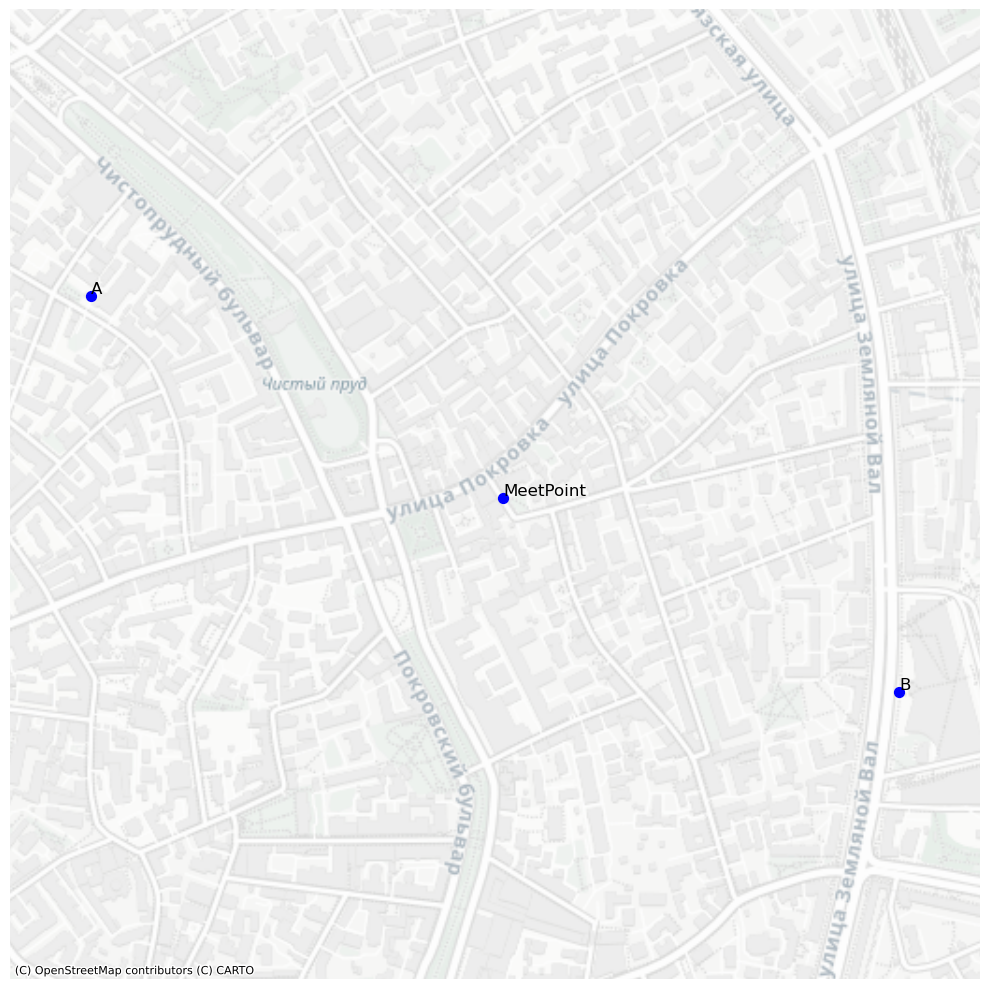

In [ ]:
import contextily as cx  # type: ignore
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from routingpy import Valhalla  # type: ignore
from shapely.geometry import LineString, Point

"""
Поиск оптимальной точки встречи для двух людей,
которые двигаются пешком по графу.
Точки-кандидаты расположены вдоль линии, соединяющей A и B.
"""

# Блок 1: Зададим местоположение людей A и B
point_a = Point(37.639478, 55.762200)
point_b = Point(37.658026, 55.757094)

# Блок 2: Создадим точки-кандидаты оптимальной точки встречи
line = LineString([point_a, point_b])
n_candidates = 50
lons = np.linspace(point_a.x, point_b.x, n_candidates)
lats = np.linspace(point_a.y, point_b.y, n_candidates)
candidates = [Point(lon, lat) for lon, lat in zip(lons, lats)]

# Блок 3: Построим матрицу от A и B до всех кандидатов
# Инициализация клиента Valhalla с автоматической обработкой повторных запросов и ошибок
client = Valhalla(
    base_url="https://valhalla1.openstreetmap.de",
    timeout=10,
    retry_timeout=60,
    retry_over_query_limit=True,
    skip_api_error=True,
)

# Построение матрицы
start_points = [[point_a.x, point_a.y], [point_b.x, point_b.y]]
targets = [[p.x, p.y] for p in candidates]
matrix = client.matrix(
    locations=start_points + targets,
    profile="pedestrian",
    sources=list(range(len(start_points))),
    destinations=list(range(len(start_points), len(start_points) + len(targets))),
    preference="fastest",
)

# Блок 4: Поиск оптимальной точки встречи
# Получим значения времени для пути из A и B до всех кандидатов
durations_from_a = matrix.durations[0]  # время из A до всех кандидатов
durations_from_b = matrix.durations[1]  # время из B до всех кандидатов

# Ищем minimax
best_idx = None
best_val = None
for i, (time_from_a, time_from_b) in enumerate(zip(durations_from_a, durations_from_b)):
    # если до какой-то точки-кандидата нет пути, то пропускаем такую точку
    if time_from_a is None or time_from_b is None:
        continue
    # определяем максимальное время до точки-кандидата для каждого из людей
    val = max(time_from_a, time_from_b)
    # находим когда это максимальное время минимально (минимакс)
    if best_val is None or val < best_val:
        best_val = val
        best_idx = i
if best_idx is None:
    raise ValueError("Не найдено подходящей точки встречи")

# Блок 5: Результаты
# Выводим информацию о оптимальной точке встречи
best_meetpoint = candidates[best_idx]
print("Оптимальная точка встречи:", (round(best_meetpoint.y, 6), round(best_meetpoint.x, 6)))
print(
    f"Время от A: {durations_from_a[best_idx] / 60:.1f} мин, от B: {durations_from_b[best_idx] / 60:.1f} мин."
)

# Визуализируем результат на карте
gdf = gpd.GeoDataFrame(
    {"role": ["A", "B", "MeetPoint"]},
    geometry=[point_a, point_b, best_meetpoint],
    crs="EPSG:4326",
)
gdf_web = gdf.to_crs("EPSG:3857")

fig, ax = plt.subplots(figsize=(10, 10))

# Зададим границы области отображения квадратными и с запасом
# Это необходимо для случаев когда точки расположены примерно на одной линии
xmin, ymin, xmax, ymax = gdf_web.total_bounds
xrange = float(xmax - xmin)
yrange = float(ymax - ymin)
buffer = max(xrange, yrange) * 0.2
max_range = max(xrange, yrange) + buffer
xmid = (xmin + xmax) / 2
ymid = (ymin + ymax) / 2
xmin, xmax = xmid - max_range / 2, xmid + max_range / 2
ymin, ymax = ymid - max_range / 2, ymid + max_range / 2
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

cx.add_basemap(ax, crs=gdf_web.crs, source=cx.providers.CartoDB.Positron)
gdf_web.plot(ax=ax, color="blue", markersize=50)
# Подписи для точек
for x, y, label in zip(gdf_web.geometry.x, gdf_web.geometry.y, gdf_web["role"]):
    ax.text(float(x), float(y), label, fontsize=12, va="bottom", color="black")
ax.set_axis_off()
plt.tight_layout()
plt.show()